This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Zonal Statistics Example

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

## Setup Examples

In [2]:
def testplot(cats, catsavg, xy, data,
             levels=[0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100],
             title=""):
    """Quick test plot layout for this example file
    """
    colors = pl.cm.viridis(np.linspace(0, 1, len(levels)))
    mycmap, mynorm = from_levels_and_colors(levels, colors, extend="max")

    radolevels = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 100]
    radocolors = pl.cm.viridis(np.linspace(0, 1, len(radolevels)))
    radocmap, radonorm = from_levels_and_colors(radolevels, radocolors,
                                                extend="max")

    fig = pl.figure(figsize=(10, 16))

    # Average rainfall sum
    ax = fig.add_subplot(211, aspect="equal")
    coll = PatchCollection(cats, array=catsavg, cmap=mycmap, norm=mynorm,
                           edgecolors='white', lw=0.5)
    ax.add_collection(coll)
    ax.autoscale()
    pl.colorbar(coll, ax=ax, shrink=0.5)
    pl.xlabel("UTM Zone 32 Easting")
    pl.ylabel("UTM Zone 32 Northing")
    pl.title(title)
    pl.draw()

    # Original radar data
    ax1 = fig.add_subplot(212, aspect="equal")
    pm = pl.pcolormesh(xy[:, :, 0], xy[:, :, 1], np.ma.masked_invalid(data),
                        cmap=radocmap, norm=radonorm)
    coll = PatchCollection(cats, facecolor='None', edgecolor='white', lw=0.5)
    ax1.add_collection(coll)
    cb = pl.colorbar(pm, ax=ax1, shrink=0.5)
    cb.set_label("(mm/h)")
    pl.xlabel("UTM Zone 32 Easting")
    pl.ylabel("UTM Zone 32 Northing")
    pl.title("Original radar rain sums")
    pl.draw()
    pl.tight_layout()

## Zonal Stats Rectangular Grid

In [3]:
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
import matplotlib.patches as patches
import datetime as dt
from osgeo import osr

In [4]:
# check for GEOS enabled GDAL
if not wrl.util.has_geos():
    print("NO GEOS support within GDAL, aborting...")
    exit(0)

In [5]:
# Get RADOLAN grid coordinates
grid_xy_radolan = wrl.georef.get_radolan_grid(900, 900)
x_radolan = grid_xy_radolan[:, :, 0]
y_radolan = grid_xy_radolan[:, :, 1]

# create radolan projection osr object
proj_stereo = wrl.georef.create_osr("dwd-radolan")

# create UTM Zone 32 projection osr object
proj_utm = osr.SpatialReference()
proj_utm.ImportFromEPSG(32632)

# transform radolan polar stereographic projection to UTM Zone 32
xy = wrl.georef.reproject(grid_xy_radolan,
                          projection_source=proj_stereo,
                          projection_target=proj_utm)

# Open shapefile (in GK2)
proj_gk2 = osr.SpatialReference()
proj_gk2.ImportFromEPSG(31466)
shpfile = wrl.util.get_wradlib_data_file('shapefiles/agger/agger_merge.shp')
dataset, inLayer = wrl.io.open_vector(shpfile)
cats, keys = wrl.georef.get_vector_coordinates(inLayer, dest_srs=proj_utm, source_srs=proj_gk2)

# Read and prepare the actual data (RADOLAN)
f = wrl.util.get_wradlib_data_file(
    'radolan/misc/raa01-sf_10000-1406100050-dwd---bin.gz')
data, attrs = wrl.io.read_radolan_composite(f, missing=np.nan)
sec = attrs['secondary']
data.flat[sec] = np.nan

# Reduce grid size using a bounding box (to enhancing performance)
bbox = inLayer.GetExtent()
bbox = wrl.georef.reproject([[bbox[0], bbox[2]], [bbox[1], bbox[3]]],
                            projection_source=proj_gk2,
                            projection_target=proj_utm)
bbox = (bbox[0, 0], bbox[1, 0], bbox[0, 1], bbox[1, 1])

buffer = 5000.
bbox = dict(left=bbox[0] - buffer, right=bbox[1] + buffer,
            bottom=bbox[2] - buffer, top=bbox[3] + buffer)
mask = (((xy[..., 1] > bbox['bottom']) & (xy[..., 1] < bbox['top'])) &
        ((xy[..., 0] > bbox['left']) & (xy[..., 0] < bbox['right'])))
xy_ = np.vstack((xy[..., 0][mask].ravel(), xy[..., 1][mask].ravel())).T
data_ = data[mask]

In [6]:
###########################################################################
# Approach #1: Assign grid points to each polygon and compute the average.
#
# - Uses matplotlib.path.Path
# - Each point is weighted equally (assumption: polygon >> grid cell)
# - this is quick, but theoretically dirty
###########################################################################

t1 = dt.datetime.now()

# Create instance of type ZonalDataPoint from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoint(xy_, cats, srs=proj_utm, buf=500.)
# dump to file (for later use - see below)
zd.dump_vector('test_zonal_points_cart')
# Create instance of type ZonalStatsPoint from zonal data object
obj1 = wrl.zonalstats.ZonalStatsPoint(zd)

isecs1 = obj1.zdata.isecs  # for plotting (see below)

t2 = dt.datetime.now()

# Compute stats for target polygons
avg1 = obj1.mean(data_.ravel())
var1 = obj1.var(data_.ravel())

t3 = dt.datetime.now()

# Create instance of type ZonalStatsPoint from zonal data file
# (much faster)
obj1 = wrl.zonalstats.ZonalStatsPoint('test_zonal_points_cart')

t4 = dt.datetime.now()

print("Approach #1 computation time:")
print("\tCreate object from scratch: %f "
      "seconds" % (t2 - t1).total_seconds())
print("\tCreate object from dumped file: %f "
      "seconds" % (t4 - t3).total_seconds())
print("\tCompute stats using object: %f "
      "seconds" % (t3 - t2).total_seconds())

# PLOTTING Approach #1

# Just a test for plotting results with zero buffer
zd2 = wrl.zonalstats.ZonalDataPoint(xy_, cats, buf=0)
# Create instance of type ZonalStatsPoint from zonal data object
obj2 = wrl.zonalstats.ZonalStatsPoint(zd2)
isecs2 = obj2.zdata.isecs

Approach #1 computation time:
	Create object from scratch: 1.814969 seconds
	Create object from dumped file: 0.085846 seconds
	Compute stats using object: 0.007933 seconds


Text(0.5, 1.0, 'Catchment #6: Points considered for stats')

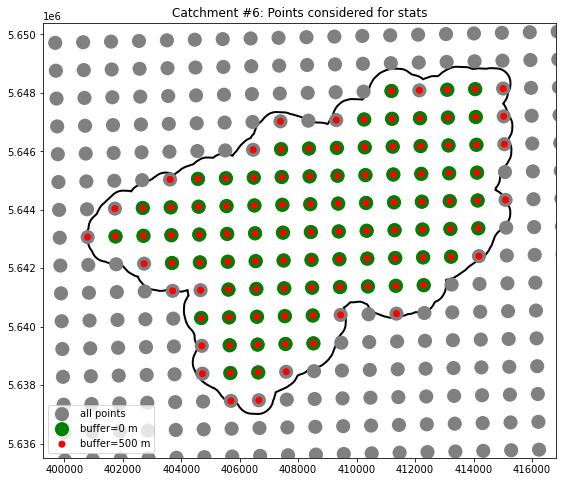

In [7]:
# Illustrate results for an example catchment i
i = 6  # try e.g. 48, 100
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, aspect="equal")

# Target polygon patches
trg_patches = [patches.Polygon(item, True) for item in obj1.zdata.trg.data]
trg_patch = [trg_patches[i]]
p = PatchCollection(trg_patch, facecolor="None", edgecolor="black",
                    linewidth=2)
ax.add_collection(p)

# pips
sources = obj1.zdata.src.data
pl.scatter(sources[:, 0], sources[:, 1], s=200, c="grey",
            edgecolor="None", label="all points")
pl.scatter(isecs2[i][:, 0], isecs2[i][:, 1], s=200, c="green",
            edgecolor="None", label="buffer=0 m")
pl.scatter(isecs1[i][:, 0], isecs1[i][:, 1], s=50, c="red",
            edgecolor="None", label="buffer=500 m")
bbox = wrl.zonalstats.get_bbox(cats[i][:, 0], cats[i][:, 1])
pl.xlim(bbox["left"] - 2000, bbox["right"] + 2000)
pl.ylim(bbox["bottom"] - 2000, bbox["top"] + 2000)
pl.legend()
pl.title("Catchment #%d: Points considered for stats" % i)

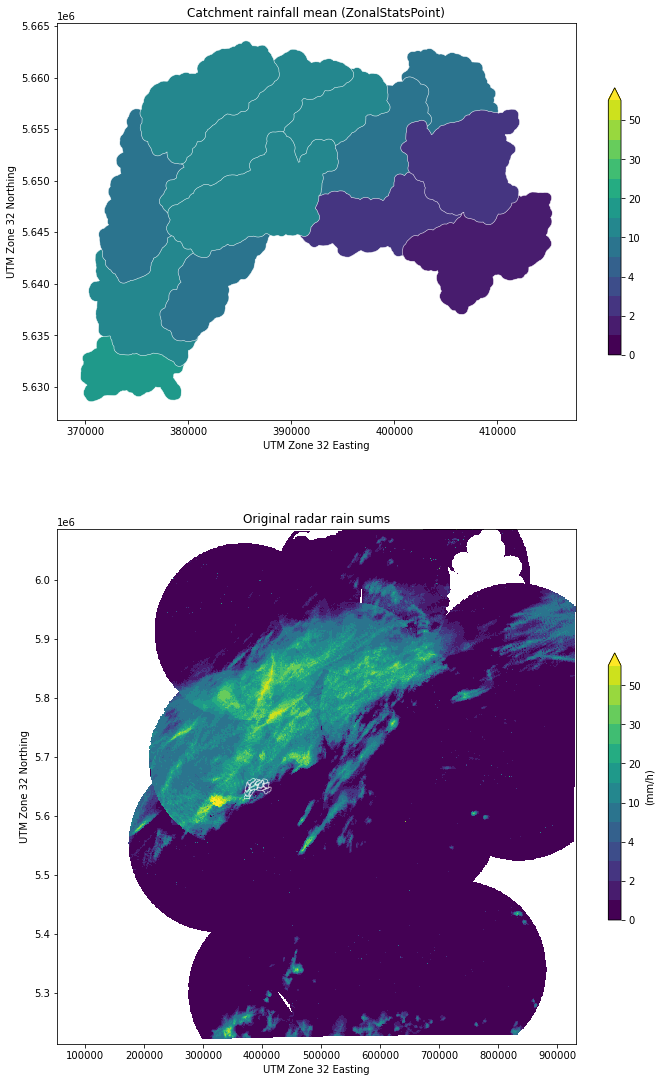

In [8]:
# Plot average rainfall and original data
testplot(trg_patches, avg1, xy, data,
         title="Catchment rainfall mean (ZonalStatsPoint)")

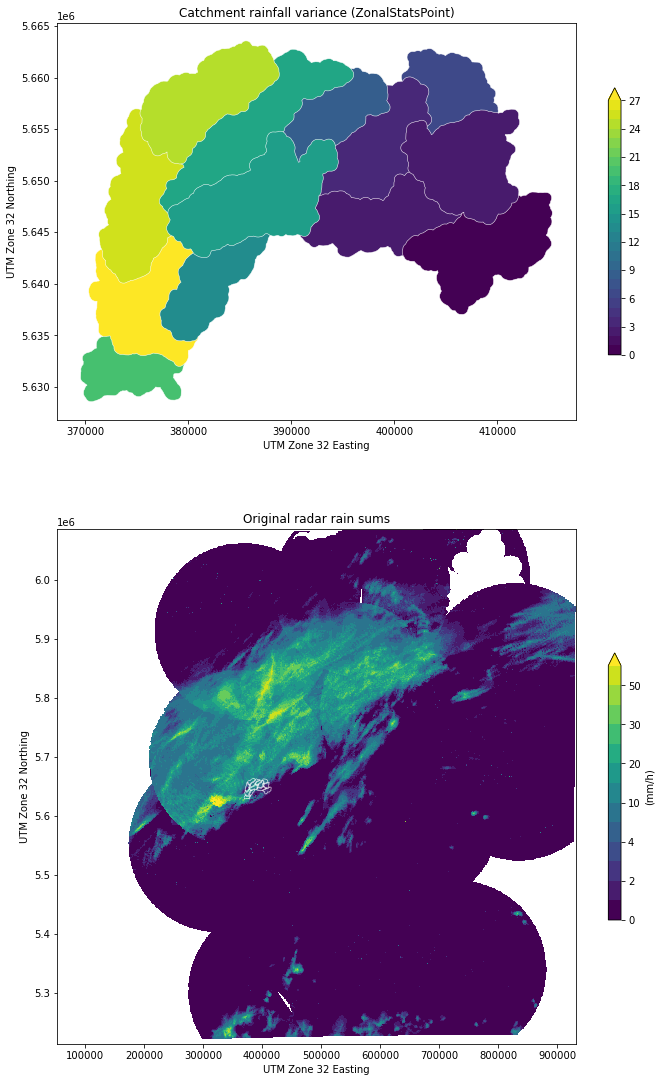

In [9]:
testplot(trg_patches, var1, xy, data,
         levels=np.arange(0, np.max(var1), 1.),
         title="Catchment rainfall variance (ZonalStatsPoint)")

In [10]:
###########################################################################
# Approach #2: Compute weighted mean based on fraction of source polygons
# in target polygons
#
# - This is more accurate (no assumptions), but probably slower...
###########################################################################

# Create vertices for each grid cell
# (MUST BE DONE IN NATIVE RADOLAN COORDINATES)
grdverts = wrl.zonalstats.grid_centers_to_vertices(x_radolan[mask],
                                                   y_radolan[mask], 1.,
                                                   1.)
# And reproject to Cartesian reference system (here: UTM Zone 32)
grdverts = wrl.georef.reproject(grdverts,
                                projection_source=proj_stereo,
                                projection_target=proj_utm)

t1 = dt.datetime.now()

# Create instance of type ZonalDataPoly from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoly(grdverts, cats, srs=proj_utm)
# dump to file
zd.dump_vector('test_zonal_poly_cart')
# Create instance of type ZonalStatsPoint from zonal data object
obj3 = wrl.zonalstats.ZonalStatsPoly(zd)

t2 = dt.datetime.now()

# Compute stats for target polygons
avg3 = obj3.mean(data_.ravel())
var3 = obj3.var(data_.ravel())

t3 = dt.datetime.now()

# Create instance of type ZonalStatsPoly from zonal data file
obj3 = wrl.zonalstats.ZonalStatsPoly('test_zonal_poly_cart')

t4 = dt.datetime.now()

print("Approach #2 computation time:")
print("\tCreate object from scratch: %f "
      "seconds" % (t2 - t1).total_seconds())
print("\tCreate object from dumped file: %f "
      "seconds" % (t4 - t3).total_seconds())
print("\tCompute stats using object: %f "
      "seconds" % (t3 - t2).total_seconds())

Approach #2 computation time:
	Create object from scratch: 0.524286 seconds
	Create object from dumped file: 0.093515 seconds
	Compute stats using object: 0.007744 seconds


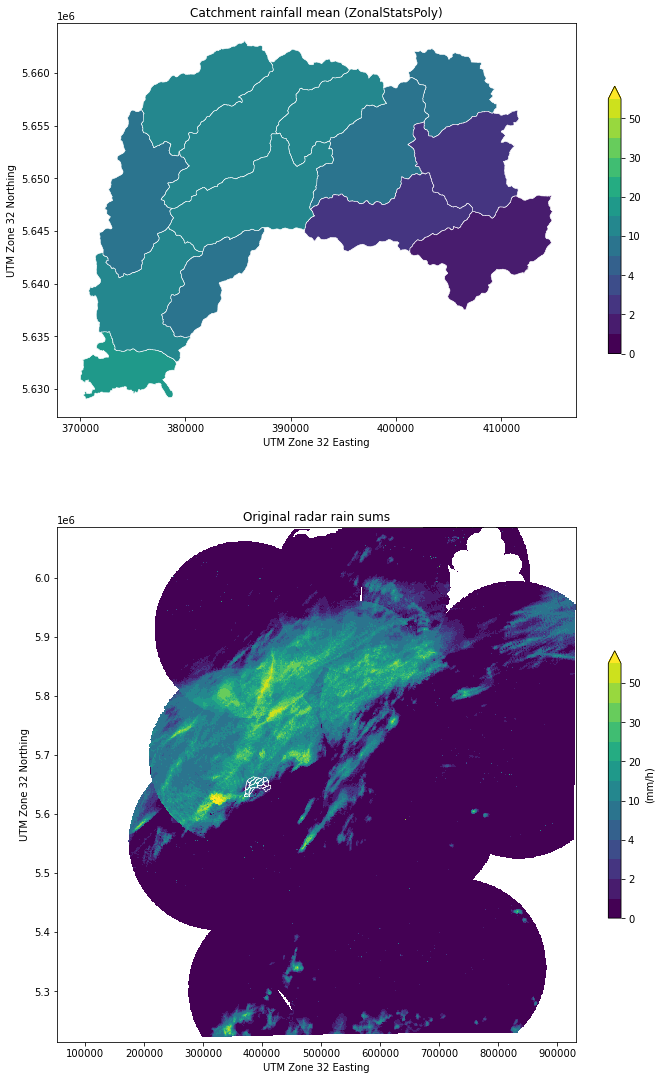

In [11]:
# PLOTTING Approach #2

# Target polygon patches
trg_patches = [patches.Polygon(item, True) for item in obj3.zdata.trg.data]

# Plot average rainfall and original data
testplot(trg_patches, avg3, xy, data,
         title="Catchment rainfall mean (ZonalStatsPoly)")

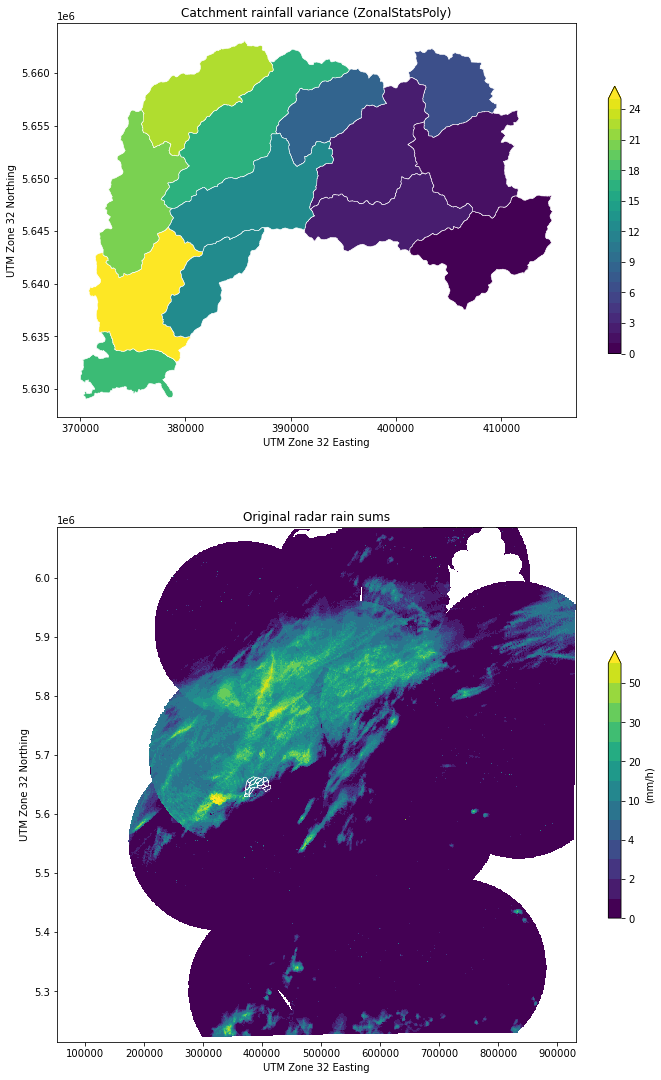

In [12]:
testplot(trg_patches, var3, xy, data,
         levels=np.arange(0, np.max(var3), 1.),
         title="Catchment rainfall variance (ZonalStatsPoly)")

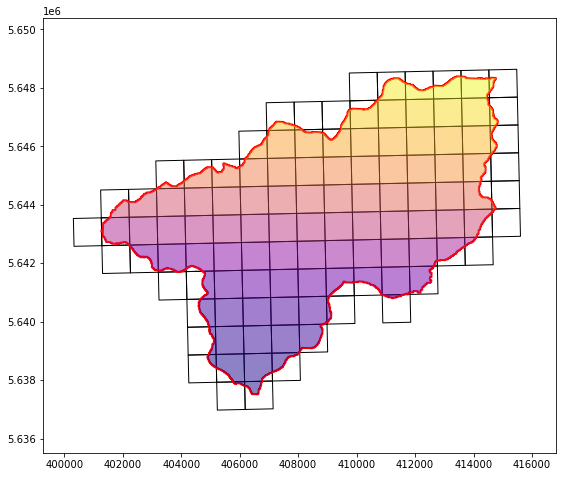

In [13]:
# Illustrate results for an example catchment i
i = 6  # try any index between 0 and 13
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, aspect="equal")

# Grid cell patches
src_index = obj3.zdata.get_source_index(i)
grd_patches = [patches.Polygon(item)
               for item in obj3.zdata.src.get_data_by_idx(src_index)]
p = PatchCollection(grd_patches, facecolor="None", edgecolor="black")
ax.add_collection(p)

# Target polygon patches
trg_patch = [trg_patches[i]]
p = PatchCollection(trg_patch, facecolor="None", edgecolor="red",
                    linewidth=2)
ax.add_collection(p)

# View the actual intersections
isecs = obj3.zdata.get_isec(i)
isec_patches = wrl.zonalstats.numpy_to_pathpatch(isecs)
colors = 100 * np.linspace(0, 1., len(isec_patches))
p = PatchCollection(isec_patches, cmap=pl.cm.plasma, alpha=0.5)
p.set_array(np.array(colors))
ax.add_collection(p)

bbox = wrl.zonalstats.get_bbox(cats[i][:, 0], cats[i][:, 1])
pl.xlim(bbox["left"] - 2000, bbox["right"] + 2000)
pl.ylim(bbox["bottom"] - 2000, bbox["top"] + 2000)
pl.draw()

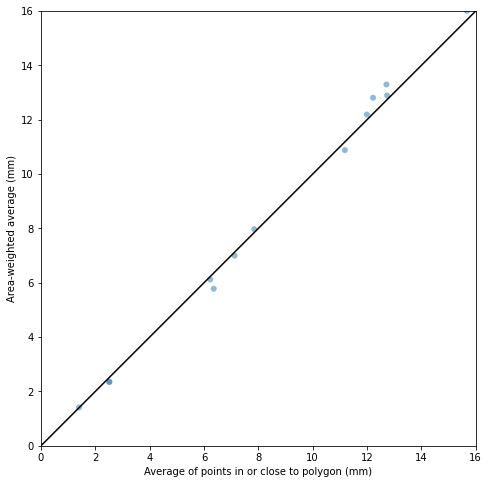

In [14]:
# Compare estimates
maxlim = np.max(np.concatenate((avg1, avg3)))
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, aspect="equal")
pl.scatter(avg1, avg3, edgecolor="None", alpha=0.5)
pl.xlabel("Average of points in or close to polygon (mm)")
pl.ylabel("Area-weighted average (mm)")
pl.xlim(0, maxlim)
pl.ylim(0, maxlim)
pl.plot([-1, maxlim + 1], [-1, maxlim + 1], color="black")
pl.show()

## Zonal Stats Polar Grid

In [15]:
filename = wrl.util.get_wradlib_data_file('hdf5/rainsum_boxpol_20140609.h5')
data, attrib = wrl.io.from_hdf5(filename)

# get Lat, Lon, range, azimuth, rays, bins out of radar data
lat1 = attrib['Latitude']
lon1 = attrib['Longitude']
r1 = attrib['r']
a1 = attrib['az']

rays = a1.shape[0]
bins = r1.shape[0]

# setup OSR objects
# create UTM Zone 32 projection osr object
proj_utm = osr.SpatialReference()
proj_utm.ImportFromEPSG(32632)

# create polar grid polygon vertices in GK2
radar_utm = wrl.georef.spherical_to_polyvert(r1, a1, 0, (lon1, lat1), 
                                             proj=proj_utm)
radar_utm = radar_utm[..., 0:2]

# create polar grid centroids in GK2
radar_utmc = wrl.georef.spherical_to_centroids(r1, a1, 0, (lon1, lat1),
                                               proj=proj_utm)
radar_utmc = radar_utmc[..., 0:2]

# reshape
radar_utm.shape = (rays, bins, 5, 2)
radar_utmc.shape = (rays, bins, 2)
shpfile = wrl.util.get_wradlib_data_file('shapefiles/agger/agger_merge.shp')
proj_gk = osr.SpatialReference()
proj_gk.ImportFromEPSG(31466)
dataset, inLayer = wrl.io.open_vector(shpfile)

cats, keys = wrl.georef.get_vector_coordinates(inLayer, dest_srs=proj_utm, source_srs=proj_gk2)


# create synthetic box
box = np.array([[390000., 5630000.], [390000., 5640000.],
                [400000., 5640000.], [400000., 5630000.],
                [390000., 5630000.]])
l = list(cats)

# Todo: remove after testing
l = l[0:3]

l.append(box)
cats = np.array(l)
bbox = inLayer.GetExtent()
bbox = wrl.georef.reproject([[bbox[0], bbox[2]], [bbox[1], bbox[3]]],
                            projection_source=proj_gk2,
                            projection_target=proj_utm)
bbox = (bbox[0, 0], bbox[1, 0], bbox[0, 1], bbox[1, 1])

# create catchment bounding box
buffer = 5000.
bbox = dict(left=bbox[0]-buffer, right=bbox[1]+buffer,
            bottom=bbox[2]-buffer, top=bbox[3]+buffer)

mask = (((radar_utmc[..., 1] > bbox['bottom']) & (radar_utmc[..., 1] < bbox['top'])) &
        ((radar_utmc[..., 0] > bbox['left']) & (radar_utmc[..., 0] < bbox['right'])))

radar_utmc_ = radar_utmc[mask, :]
radar_utm_ = radar_utm[mask]
data_ = data[mask]

In [16]:
###########################################################################
# Approach #1: Assign grid points to each polygon and compute the average.
#
# - Uses matplotlib.path.Path
# - Each point is weighted equally (assumption: polygon >> grid cell)
# - this is quick, but theoretically dirty
# - for polar grids a range-area dependency has to be taken into account
###########################################################################

t1 = dt.datetime.now()

# Create instance of type ZonalDataPoint from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoint(radar_utmc_, cats, srs=proj_utm,
                                   buf=500.)
# dump to file
zd.dump_vector('test_zonal_points')
# Create instance of type ZonalStatsPoint from zonal data object
obj1 = wrl.zonalstats.ZonalStatsPoint(zd)

isecs1 = obj1.zdata.isecs
t2 = dt.datetime.now()

# Compute stats for target polygons
avg1 = obj1.mean(data_.ravel())
var1 = obj1.var(data_.ravel())

t3 = dt.datetime.now()

# Create instance of type ZonalStatsPoint from zonal data file
obj1 = wrl.zonalstats.ZonalStatsPoint('test_zonal_points')

t4 = dt.datetime.now()

print ("Approach #1 computation time:")
print(
"\tCreate object from scratch: %f seconds" % (t2 - t1).total_seconds())
print(
"\tCreate object from dumped file: %f seconds" % (t4 - t3).total_seconds())
print(
"\tCompute stats using object: %f seconds" % (t3 - t2).total_seconds())

Approach #1 computation time:
	Create object from scratch: 3.263817 seconds
	Create object from dumped file: 0.566729 seconds
	Compute stats using object: 0.003005 seconds


In [17]:
# PLOTTING Approach #2

# Just a test for plotting results with zero buffer
zd = wrl.zonalstats.ZonalDataPoint(radar_utmc_, cats, buf=0)
# Create instance of type ZonalStatsPoint from zonal data object
obj2 = wrl.zonalstats.ZonalStatsPoint(zd)
isecs2 = obj2.zdata.isecs

Text(0.5, 1.0, 'Catchment #0: Points considered for stats')

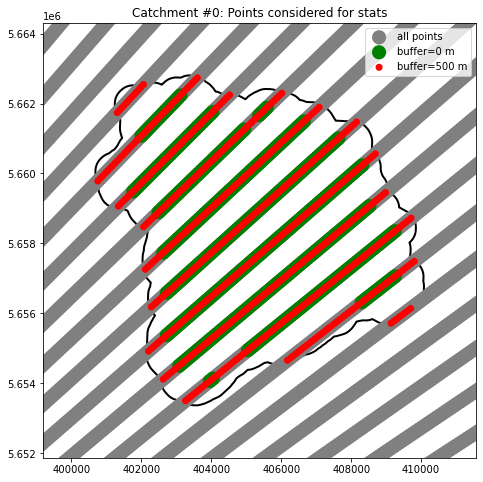

In [18]:
# Illustrate results for an example catchment i
i = 0  # try e.g. 6, 12
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, aspect="equal")

# Target polygon patches
trg_patches = [patches.Polygon(item, True) for item in obj1.zdata.trg.data]
trg_patch = [trg_patches[i]]
p = PatchCollection(trg_patch, facecolor="None", edgecolor="black",
                    linewidth=2)
ax.add_collection(p)

# pips
sources = obj1.zdata.src.data
pl.scatter(sources[:, 0], sources[:, 1], s=200, c="grey",
           edgecolor="None", label="all points")
pl.scatter(isecs2[i][:, 0], isecs2[i][:, 1], s=200, c="green",
           edgecolor="None", label="buffer=0 m")
pl.scatter(isecs1[i][:, 0], isecs1[i][:, 1], s=50, c="red",
           edgecolor="None", label="buffer=500 m")
bbox = wrl.zonalstats.get_bbox(cats[i][:, 0], cats[i][:, 1])
pl.xlim(bbox["left"] - 2000, bbox["right"] + 2000)
pl.ylim(bbox["bottom"] - 2000, bbox["top"] + 2000)
pl.legend()
pl.title("Catchment #%d: Points considered for stats" % i)

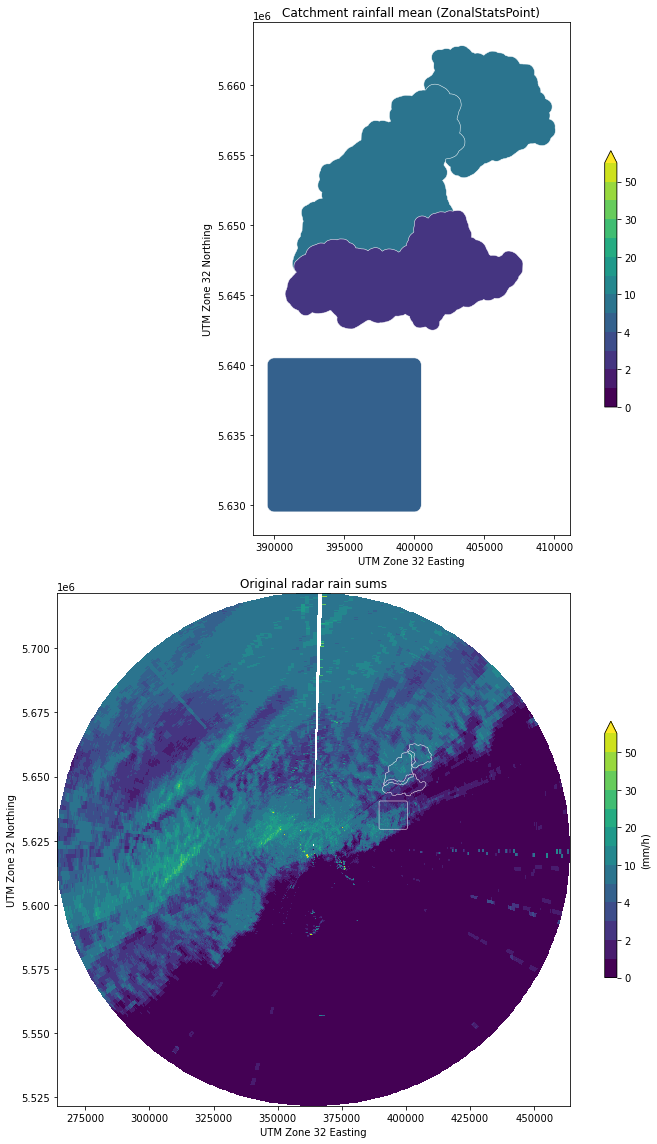

In [19]:
# Plot average rainfall and original data
testplot(trg_patches, avg1, radar_utmc, data,
         title="Catchment rainfall mean (ZonalStatsPoint)")

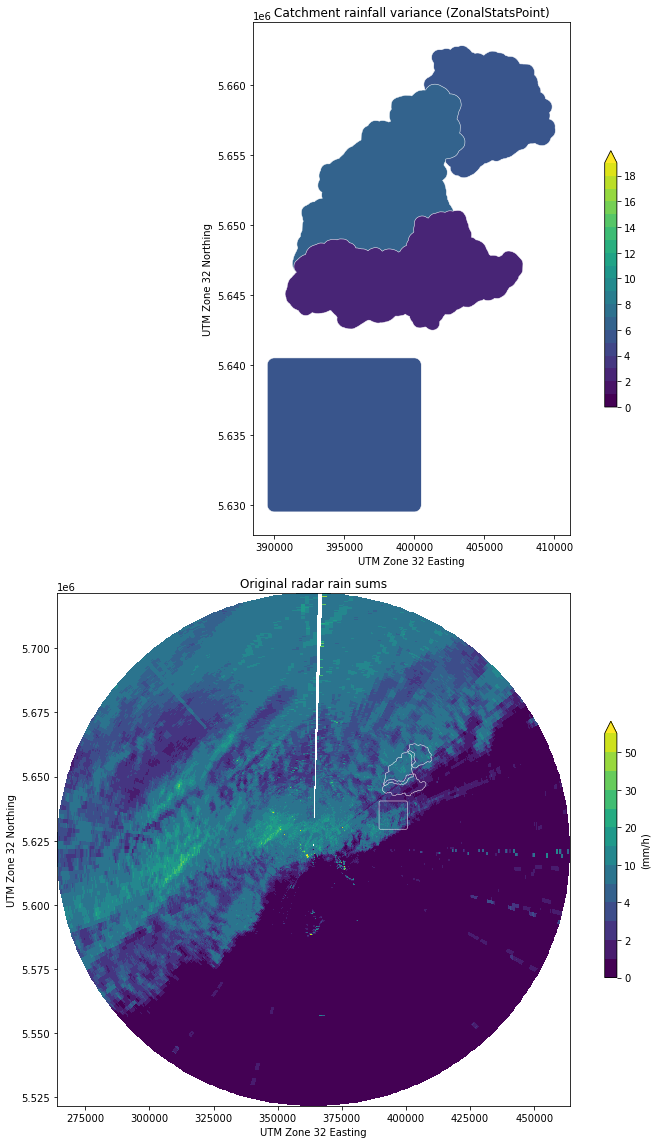

In [20]:
testplot(trg_patches, var1, radar_utmc, data, levels=np.arange(0, 20, 1.0),
         title="Catchment rainfall variance (ZonalStatsPoint)")

In [21]:
###########################################################################
# Approach #2: Compute weighted mean based on fraction of source polygons
# in target polygons
#
# - This is more accurate (no assumptions), but probably slower...
###########################################################################

t1 = dt.datetime.now()

# Create instance of type ZonalDataPoly from source grid and
# catchment array
zd = wrl.zonalstats.ZonalDataPoly(radar_utm_, cats, srs=proj_utm)
# dump to file
zd.dump_vector('test_zonal_poly')
# Create instance of type ZonalStatsPoint from zonal data object
obj3 = wrl.zonalstats.ZonalStatsPoly(zd)

obj3.zdata.dump_vector('test_zonal_poly')
t2 = dt.datetime.now()

avg3 = obj3.mean(data_.ravel())
var3 = obj3.var(data_.ravel())

t3 = dt.datetime.now()

# Create instance of type ZonalStatsPoly from zonal data file
obj4 = wrl.zonalstats.ZonalStatsPoly('test_zonal_poly')

t4 = dt.datetime.now()

print ("Approach #2 computation time:")
print(
"\tCreate object from scratch: %f seconds" % (t2 - t1).total_seconds())
print(
"\tCreate object from dumped file: %f seconds" % (t4 - t3).total_seconds())
print(
"\tCompute stats using object: %f seconds" % (t3 - t2).total_seconds())

obj3.zdata.trg.dump_raster('test_zonal_hdr.nc', 'netCDF', 'mean',
                           pixel_size=100.)

obj3.zdata.trg.dump_vector('test_zonal_shp')
obj3.zdata.trg.dump_vector('test_zonal_json.geojson', 'GeoJSON')

# Target polygon patches
trg_patches = [patches.Polygon(item, True) for item in obj3.zdata.trg.data]

Approach #2 computation time:
	Create object from scratch: 3.823470 seconds
	Create object from dumped file: 0.591655 seconds
	Compute stats using object: 0.003265 seconds


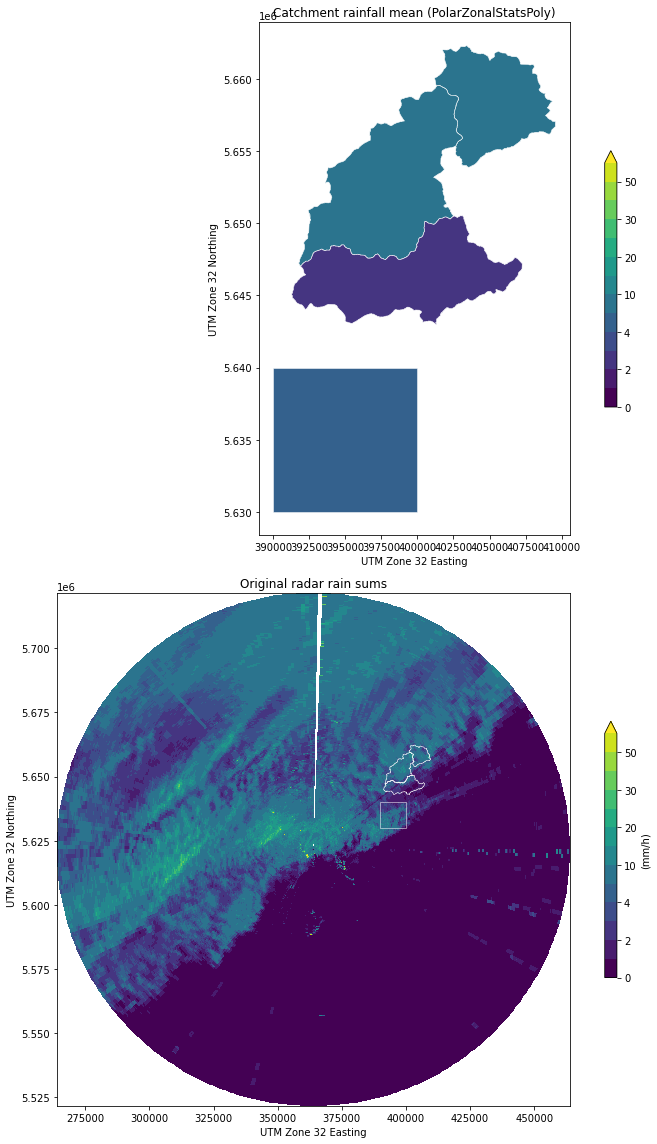

In [22]:
# Plot average rainfall and original data
testplot(trg_patches, avg3, radar_utmc, data,
         title="Catchment rainfall mean (PolarZonalStatsPoly)")

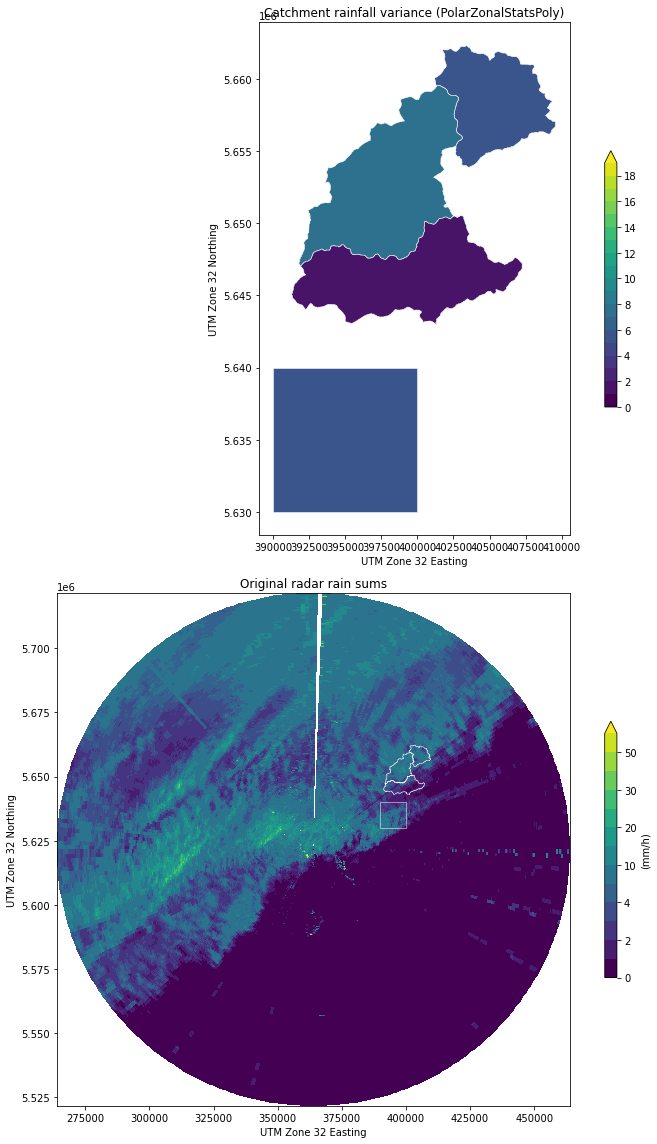

In [23]:
testplot(trg_patches, var3, radar_utmc, data, levels=np.arange(0, 20, 1.0),
         title="Catchment rainfall variance (PolarZonalStatsPoly)")

plot intersection takes: 0.189329 seconds


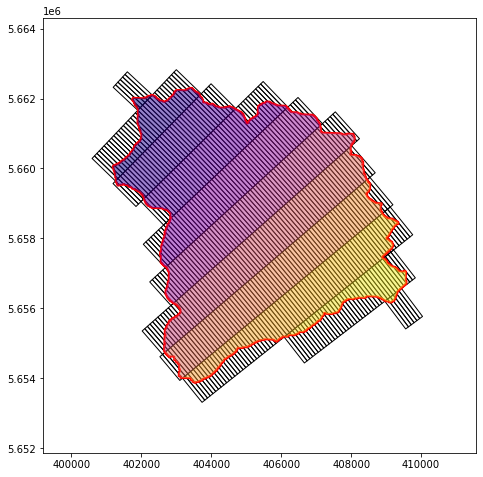

In [24]:
# Illustrate results for an example catchment i
i = 0  # try any index between 0 and 13
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, aspect="equal")

# Grid cell patches
src_index = obj3.zdata.get_source_index(i)
grd_patches = [patches.Polygon(item) for item in
               obj3.zdata.src.get_data_by_idx(src_index)]
p = PatchCollection(grd_patches, facecolor="None", edgecolor="black")
ax.add_collection(p)

# Target polygon patches
trg_patch = [trg_patches[i]]
p = PatchCollection(trg_patch, facecolor="None", edgecolor="red",
                    linewidth=2)
ax.add_collection(p)

# View the actual intersections
t1 = dt.datetime.now()
isecs = obj3.zdata.get_isec(i)
isec_patches = wrl.zonalstats.numpy_to_pathpatch(isecs)
colors = 100 * np.linspace(0, 1., len(isec_patches))
p = PatchCollection(isec_patches, cmap=pl.cm.plasma, alpha=0.5)
p.set_array(np.array(colors))
ax.add_collection(p)

bbox = wrl.zonalstats.get_bbox(cats[i][:, 0], cats[i][:, 1])
pl.xlim(bbox["left"] - 2000, bbox["right"] + 2000)
pl.ylim(bbox["bottom"] - 2000, bbox["top"] + 2000)
pl.draw()

t2 = dt.datetime.now()
print("plot intersection takes: %f seconds" % (t2 - t1).total_seconds())

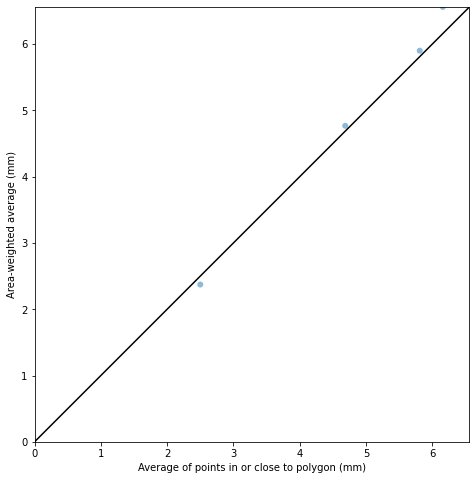

In [25]:
# Compare estimates
maxlim = np.max(np.concatenate((avg1, avg3)))
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, aspect="equal")
pl.scatter(avg1, avg3, edgecolor="None", alpha=0.5)
pl.xlabel("Average of points in or close to polygon (mm)")
pl.ylabel("Area-weighted average (mm)")
pl.xlim(0, maxlim)
pl.ylim(0, maxlim)
pl.plot([-1, maxlim + 1], [-1, maxlim + 1], color="black")
pl.show()